In [2]:
import numpy as np
# import cv2
import tifffile as tiff
from shapely.geometry import Polygon, mapping, shape, box
from skimage import io
from skimage.measure import label, regionprops
import matplotlib.pyplot as plt
# import json
from rasterio import features
import scanpy as sc
import pandas as pd
import geopandas as gpd

import pickle
import scipy

import seaborn as sns

from SGanalysis.SGobject import SGobject

import matplotlib
%matplotlib inline
# matplotlib.use('Qt5Agg')
# %matplotlib qt

# import matplotlib as mpl
matplotlib.rcParams['pdf.fonttype'] = 42

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['Arial']

plt.rcParams['font.size'] = 6  # Set default font size for all text elements
plt.rcParams['axes.labelsize'] = 8  # Set font size for axis labels
plt.rcParams['xtick.labelsize'] = 6  # Set font size for x-axis tick labels
plt.rcParams['ytick.labelsize'] = 6  # Set font size for y-axis tick labels
plt.rcParams['legend.fontsize'] = 6  # Set font size for legend text


from sklearn.cluster import AgglomerativeClustering as AggCluster

%load_ext autoreload
%autoreload 2
%reload_ext autoreload

import sys
import os

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/SpatialBarcodes/analysis/tools/tools.py'

tools_path = '../helperScripts/tools.py'

# tools_path  = '/Users/grantkinsler/Documents/Penn/Research/SpatialBarcodes/analysis/tools/tools.py'
sys.path.append(os.path.dirname(os.path.expanduser(tools_path)))
import tools as tools

In [3]:
# filepath  = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/Shared_Grant/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'
filepath = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/projects/2024-02-27_spatialbarcodes_expression/'


# roi_2
# roi_2
roi_name = 'roi_2'

In [4]:
with open(f'{filepath}{roi_name}/exports/sg_object_decode_20240314_segmentation_1_20240806.pkl', 'rb') as f:
    sg_obj = pickle.load(f)

In [5]:
df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df = df.set_index('object_id')

# df = matrix

df.sort_index(inplace=True)

df['cell_id'] = df.index

No filtering available or applied.


/var/folders/x6/q0wb9df97nj1wnk5c4t0k7840000gn/T/ipykernel_54136/755052625.py:13: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  df['cell_id'] = df.index


In [6]:
df = sg_obj.get_cell_gene_table_df()

cutoff = 3

cell_barcodes = {}
# matrix.set_index('object_id',   inplace=True)
df.set_index('object_id')

# df = matrix

df.sort_index(inplace=True)

df['cell_id'] = df.index

barcode_cols = ['bc_{:03d}'.format(i) for i in range(1,97)]

for cell_id in df['cell_id']:
    this_cell = df[df['cell_id']==cell_id]
    cell_barcodes[cell_id] = []

    for bc in barcode_cols:
        if this_cell[bc].values[0] > cutoff:
            cell_barcodes[cell_id].append(bc)

df['called_barcodes'] = cell_barcodes.values()
df['n_called_barcodes'] = [len(bc_set) for bc_set in cell_barcodes.values()]
df['barcode_names'] = ['-'.join(sorted(bc_set)) for bc_set in cell_barcodes.values()]

# df = pd.merge(df,sg_obj.gdf,how='left',left_index=True,right_index=True)


gene_cols = [col for col in df.columns if 'bc_' not in col and col not in ['cell_id','called_barcodes','n_called_barcodes','barcode_names']]

No filtering available or applied.


In [7]:
sg_obj.gdf['object_id']

sg_obj.gdf['object_id_str'] = sg_obj.gdf['object_id'].astype(int)
df['object_id'] = [int(float(x)) for x in df['cell_id'].values]

In [8]:
image_path = '/Users/grantkinsler/RajLab Dropbox/Grant Kinsler/SpatialBarcodes/ImagingData/2024-02-27_spatialbarcodes_SG_expression/rawData/roi_2/hyb_1_aligned.tiff'


[]
['bc_002-bc_018-bc_024' 'bc_009' 'bc_025-bc_078' ...
 'bc_010-bc_014-bc_019-bc_095' 'bc_008-bc_025-bc_083-bc_086-bc_093'
 'bc_020-bc_025-bc_041-bc_060-bc_066-bc_080-bc_091']
[('bc_013', '#e31a1c'), ('bc_023', '#ff7f00'), ('bc_035', '#ffff99'), ('bc_061', '#a6cee3'), ('bc_073', '#b2df8a'), ('bc_088', '#bc80bd'), ('bc_053', '#dadaeb'), ('bc_086', '#b84203'), ('bc_022', '#686868'), ('bc_028', '#bad6eb'), ('bc_041', '#89bedc'), ('bc_044', '#539ecd'), ('bc_045', '#2b7bba'), ('bc_070', '#0b559f'), ('bc_025', '#66a9cf'), ('bc_085', '#028189'), ('bc_027', '#f07818'), ('bc_001', '#f4f4f4'), ('bc_002', '#e6e6e6'), ('bc_003', '#d4d4d4'), ('bc_004', '#bfbfbf'), ('bc_005', '#a4a4a4'), ('bc_006', '#898989'), ('bc_007', '#707070'), ('bc_008', '#575757'), ('bc_009', '#393939'), ('bc_010', '#1b1b1b'), ('bc_011', '#f4f4f4'), ('bc_012', '#e6e6e6'), ('bc_014', '#d4d4d4'), ('bc_015', '#bfbfbf'), ('bc_016', '#a4a4a4'), ('bc_017', '#898989'), ('bc_018', '#707070'), ('bc_019', '#575757'), ('bc_020', '#3939

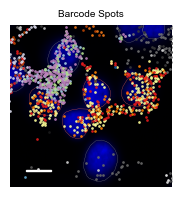

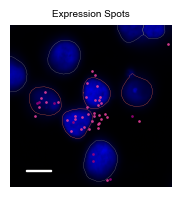

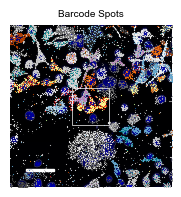

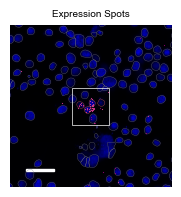

In [19]:
# clusters_of_interest = [372]
# cluster_cells = list(adata_genes[adata_genes.obs['bc_cluster']==clusters_of_interest[0]].obs['cell_id'].values)
# cluster_cells = ['37880']

scales = [1.5,10]

# dictionary of marker sizes based on the scale
marker_sizes = {1.5:15,10:3}


for scale in scales:
  for object_id in ['4957']:

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=100,id_field='object_id')

      barcode_names = tools.get_all_barcodes_in_region(df,region['object_id_str'].values,id_field='object_id')
      barcode_names = list(np.unique(barcode_names))

      
      print([name for name in barcode_names if name.count('_') >2])

      print(df[df['object_id'].isin(region['object_id_str'].values)]['barcode_names'].values)

      color_map = {
    # 'bc_013':sns.color_palette('Reds',4)[0],
    # 'bc_023':sns.color_palette('Reds',4)[1],
    # 'bc_035':sns.color_palette('Reds',4)[2],


    'bc_013':'#e31a1c',
    'bc_023':'#ff7f00',
    'bc_035':'#ffff99',
                  
    # 'bc_061':sns.color_palette('Greens',4)[0],
    # 'bc_073':sns.color_palette('Greens',4)[1],
    # 'bc_088':sns.color_palette('Greens',4)[2],

    'bc_061':'#a6cee3',
    'bc_073':'#b2df8a',
    'bc_088':'#bc80bd',

    'bc_053':sns.color_palette('Purples',3)[0],
    'bc_086':sns.color_palette('Purples',3)[1],
    'bc_022':sns.color_palette('Greys',2)[1],

    'bc_028':sns.color_palette('Blues',6)[1],
    'bc_041':sns.color_palette('Blues',6)[2],
    'bc_044':sns.color_palette('Blues',6)[3],
    'bc_045':sns.color_palette('Blues',6)[4],
    'bc_070':sns.color_palette('Blues',6)[5],

    #   'bc_045':sns.color_palette('Blues',6)[4],
    # 'bc_070':sns.color_palette('Blues',6)[5],

      'bc_025':sns.color_palette('PuBuGn',3)[1],
    'bc_085':sns.color_palette('PuBuGn',3)[2],

        'bc_027':sns.color_palette('YlOrBr',4)[2],
    'bc_086':sns.color_palette('YlOrBr',4)[3],

      }


      counter = 0
      for gene in barcode_names:
          if gene not in color_map.keys():
              color_map[gene] = sns.color_palette('Greys',10)[counter%10]
              counter+=1


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      plt.figure(figsize=(2.1,2.1))
      ax = plt.gca()

      region = tools.get_polygons_around_polygon(sg_obj,object_id,image_scale=scale,id_field='object_id')

      sisters = ['4957','4946','4900','4961']

      tools.plot_polygons_and_points(sg_obj,
                                    sisters,
                                    #  region['object_id'].values,
                                    id_field='object_id',
                                    gene_names=barcode_names,
                                    annotate=False,image_scale=scale,single_mode=False,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,
                                    exterior_marker='.',marker_size=marker_sizes[scale],ax=ax,lw=0.2,
                                    show_image=True,image_path=image_path,alpha=0.9,
                                    n_plotting_groups=5,
                                    annotate_cells=False
                                    )
      
      xmin,xmax = plt.xlim()
      ymin,ymax = plt.ylim()

      width = np.min([xmax-xmin,ymax-ymin])
      plt.xlim(np.mean([xmin,xmax])-width/2,np.mean([xmin,xmax])+width/2)
      plt.ylim(np.mean([ymin,ymax])-width/2,np.mean([ymin,ymax])+width/2)
      
      plt.title('Barcode Spots')

      if scale == scales[0]:
        box_quadrants = [np.mean([xmin,xmax])-width/2,np.mean([xmin,xmax])+width/2,np.mean([ymin,ymax])-width/2,np.mean([ymin,ymax])+width/2]
        scale_bar_length_um = 10 # 100um scale bar

      else:
         # draw rectangle of the box quadrants
        rect = matplotlib.patches.Rectangle((box_quadrants[0], box_quadrants[2]), (box_quadrants[1]-box_quadrants[0]), (box_quadrants[3]-box_quadrants[2]), linewidth=0.5, edgecolor='w', facecolor='none',zorder=1000)
        # Add the patch to the Axes
        ax.add_patch(rect)
        scale_bar_length_um = 50 # 100um scale bar

      xlims = plt.xlim()
      ylims = plt.ylim()
      scale_bar_length_px = scale_bar_length_um * 1000.0 / tools.sg_pixel_size  # px
      scale_bar = matplotlib.patches.Rectangle((xlims[0]+(0.1*(xlims[1]-xlims[0])),ylims[0]+(0.1*(ylims[1]-ylims[0]))), 
                                         scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='w', facecolor='w')
      ax.add_patch(scale_bar)
      
      plt.axis('off')
      plt.savefig(f'../graphs/in_vitro_{object_id}_region_big{scale}_barcode.pdf',bbox_inches='tight',transparent=True)

      plt.figure(figsize=(2.1,2.1))
      ax = plt.gca()
      # gene_names = ['IGFBP7','VEGFA','MITF','COL1A1','MLANA','IFIT2','MMP1','MMP11','NANOG','BMP2']
      # color_map = {'VEGFA':sns.color_palette('Reds',3)[2],
      #              'MITF':sns.color_palette('Blues',3)[1],
      #              'IGFBP7':sns.color_palette('PuRd',3)[2],
      #              'COL1A1':'g',
      #              'IFIT2':'gold',
      #              'MMP1':'orange',
      #              'MMP11':'orange',
      #              'NANOG':'k',
      #              'BMP2':'k',
      #              'MLANA':sns.color_palette('Blues',3)[2]}
      
      cluster_genes = {
          # 0:['MLANA'],
                      #  1:['VEGFA','NRG1','BIRC3'],
                      #  2:['COL1A1','COL5A2','BGN'],
                      #  3:['MMP11','BMP2','ROR2'],
                      #  4:['NANOG','TYR','ERBB3'],
                      #  5: ['TYR',],
                      6: ['OASL','IFIT2'],
                      #  7: ['MMP1','SERPINE1','NT5E'],
                      }
      
      cluster_colors = {
                        # 0:'Greys',
                        0:'dark:#D3D3D3',
                      #   1:'Reds',
                      #   2:'Greens',
                      #   3:'Oranges',
                      #   4:'Greys',
                        # 5:'Greys',
                        # 6:'Oranges',
                        # 6:'light:#ffbf00'
                        # 6:'Reds',
                        6:'RdPu',

                      #   7:'Purples'
                        }
      
      gene_names = [gene  for gene_list in cluster_genes.values() for gene in gene_list]

      color_map = {gene:sns.color_palette(cluster_colors[cluster],4)[3-g]  for cluster,gene_list in cluster_genes.items() for g,gene in enumerate(gene_list)}


      print([(g,matplotlib.colors.to_hex(c)) for (g,c) in color_map.items()])

      tools.plot_polygons_and_points(sg_obj,
                                    #  region['object_id'].values,
                                    sisters,
                                    gene_names=gene_names,
                                    annotate=False,image_scale=scale,
                                    focal_outline_color='#fb6a4a',other_outline_color='gray',
                                    interior_marker='.',color_map=color_map,single_mode=False,
                                    exterior_marker='.',marker_size=marker_sizes[scale],ax=ax,lw=0.2,
                                    show_image=True,image_path=image_path,alpha=0.9,
                                    n_plotting_groups=5,
                                    )
      
      plt.title('Expression Spots')

            
      xmin,xmax = plt.xlim()
      ymin,ymax = plt.ylim()

      width = np.min([xmax-xmin,ymax-ymin])
      plt.xlim(np.mean([xmin,xmax])-width/2,np.mean([xmin,xmax])+width/2)
      plt.ylim(np.mean([ymin,ymax])-width/2,np.mean([ymin,ymax])+width/2)

      if scale == scales[0]:
        box_quadrants = [np.mean([xmin,xmax])-width/2,np.mean([xmin,xmax])+width/2,np.mean([ymin,ymax])-width/2,np.mean([ymin,ymax])+width/2]
        scale_bar_length_um = 10 # 100um scale bar
      else:
        scale_bar_length_um = 50 # 100um scale bar
         # draw rectangle of the box quadrants
        rect = matplotlib.patches.Rectangle((box_quadrants[0], box_quadrants[2]), (box_quadrants[1]-box_quadrants[0]), (box_quadrants[3]-box_quadrants[2]), linewidth=0.5, edgecolor='w', facecolor='none',zorder=1000)
        # Add the patch to the Axes
        ax.add_patch(rect)

      
      xlims = plt.xlim()
      ylims = plt.ylim()
      scale_bar_length_px = scale_bar_length_um * 1000.0 / tools.sg_pixel_size  # px
      scale_bar = matplotlib.patches.Rectangle((xlims[0]+(0.1*(xlims[1]-xlims[0])),ylims[0]+(0.1*(ylims[1]-ylims[0]))), 
                                         scale_bar_length_px, scale_bar_length_px/20, linewidth=1, edgecolor='w', facecolor='w')
      ax.add_patch(scale_bar)
      
      
      plt.axis('off')

      plt.savefig(f'../graphs/in_vitro_{object_id}_region_big{scale}_expression.pdf',bbox_inches='tight',transparent=True)

      # plt.savefig
      # sg_obj_only_bcs.plot_polygon_and_points(mapping_dict[cell_id],gene_names=gene_names,annotate=False)